# 震源メカニズム解の表現

In [10]:
import pygmt
import numpy as np

震源メカニズムは辞書形式でデータを渡すのがわかりやすそうです．

In [11]:
meca ={
    "strike"   : [ 35,  15], 
    "dip"      : [ 45,  35], 
    "rake"     : [ 90, 120], 
    "magnitude": [  6,   4], 
    "longitude": [135, 140],
    "latitude" : [ 35,  40], 
    "depth"    : [ 30, 400]
}

この例のように，`strike, dip, rake` が指定されると自動的にAki and Richardsフォーマットが選択されます．公式マニュアルによると，その他のフォーマットは以下のような辞書項目が設定されていれば良いようです：

| format | dictionary keys |
|:------ |:---------------- |
| `aki`  | `strike`, `dip`, `rake`, `magnitude`  |
| `gcmt`  | `strike1`, `dip1`, `rake1`, `strike2`, `dip2`, `rake2`, `mantissa`, `exponent`  |
| `mt`  | `mrr`, `mtt`, `mff`, `mrt`, `mrf`, `mtf`, `exponent`  |
| `partial`  | `strike1`, `dip1`, `strike2`, `fault_type`, `magnitude`  |
| `principal_axis` | `t_exponent`, `t_azimuth`, `t_plunge`, `n_exponent`, `n_azimuth`, `n_plunge`, `p_exponent`, `p_azimuth`, `p_plunge`, `exponent`  |

`spec` として渡された辞書のkeyに基づいて，フォーマットが自動判定されます．

複数のメカニズム解を表現したい場合は，辞書のそれぞれのキーに対応する値をリストやタプルにします．同じ構造を持つ辞書全体のリストを一括で処理することはできないようです．（とはいえ，Pythonの `for` 構文と組み合わせればそれは容易に実現できます）


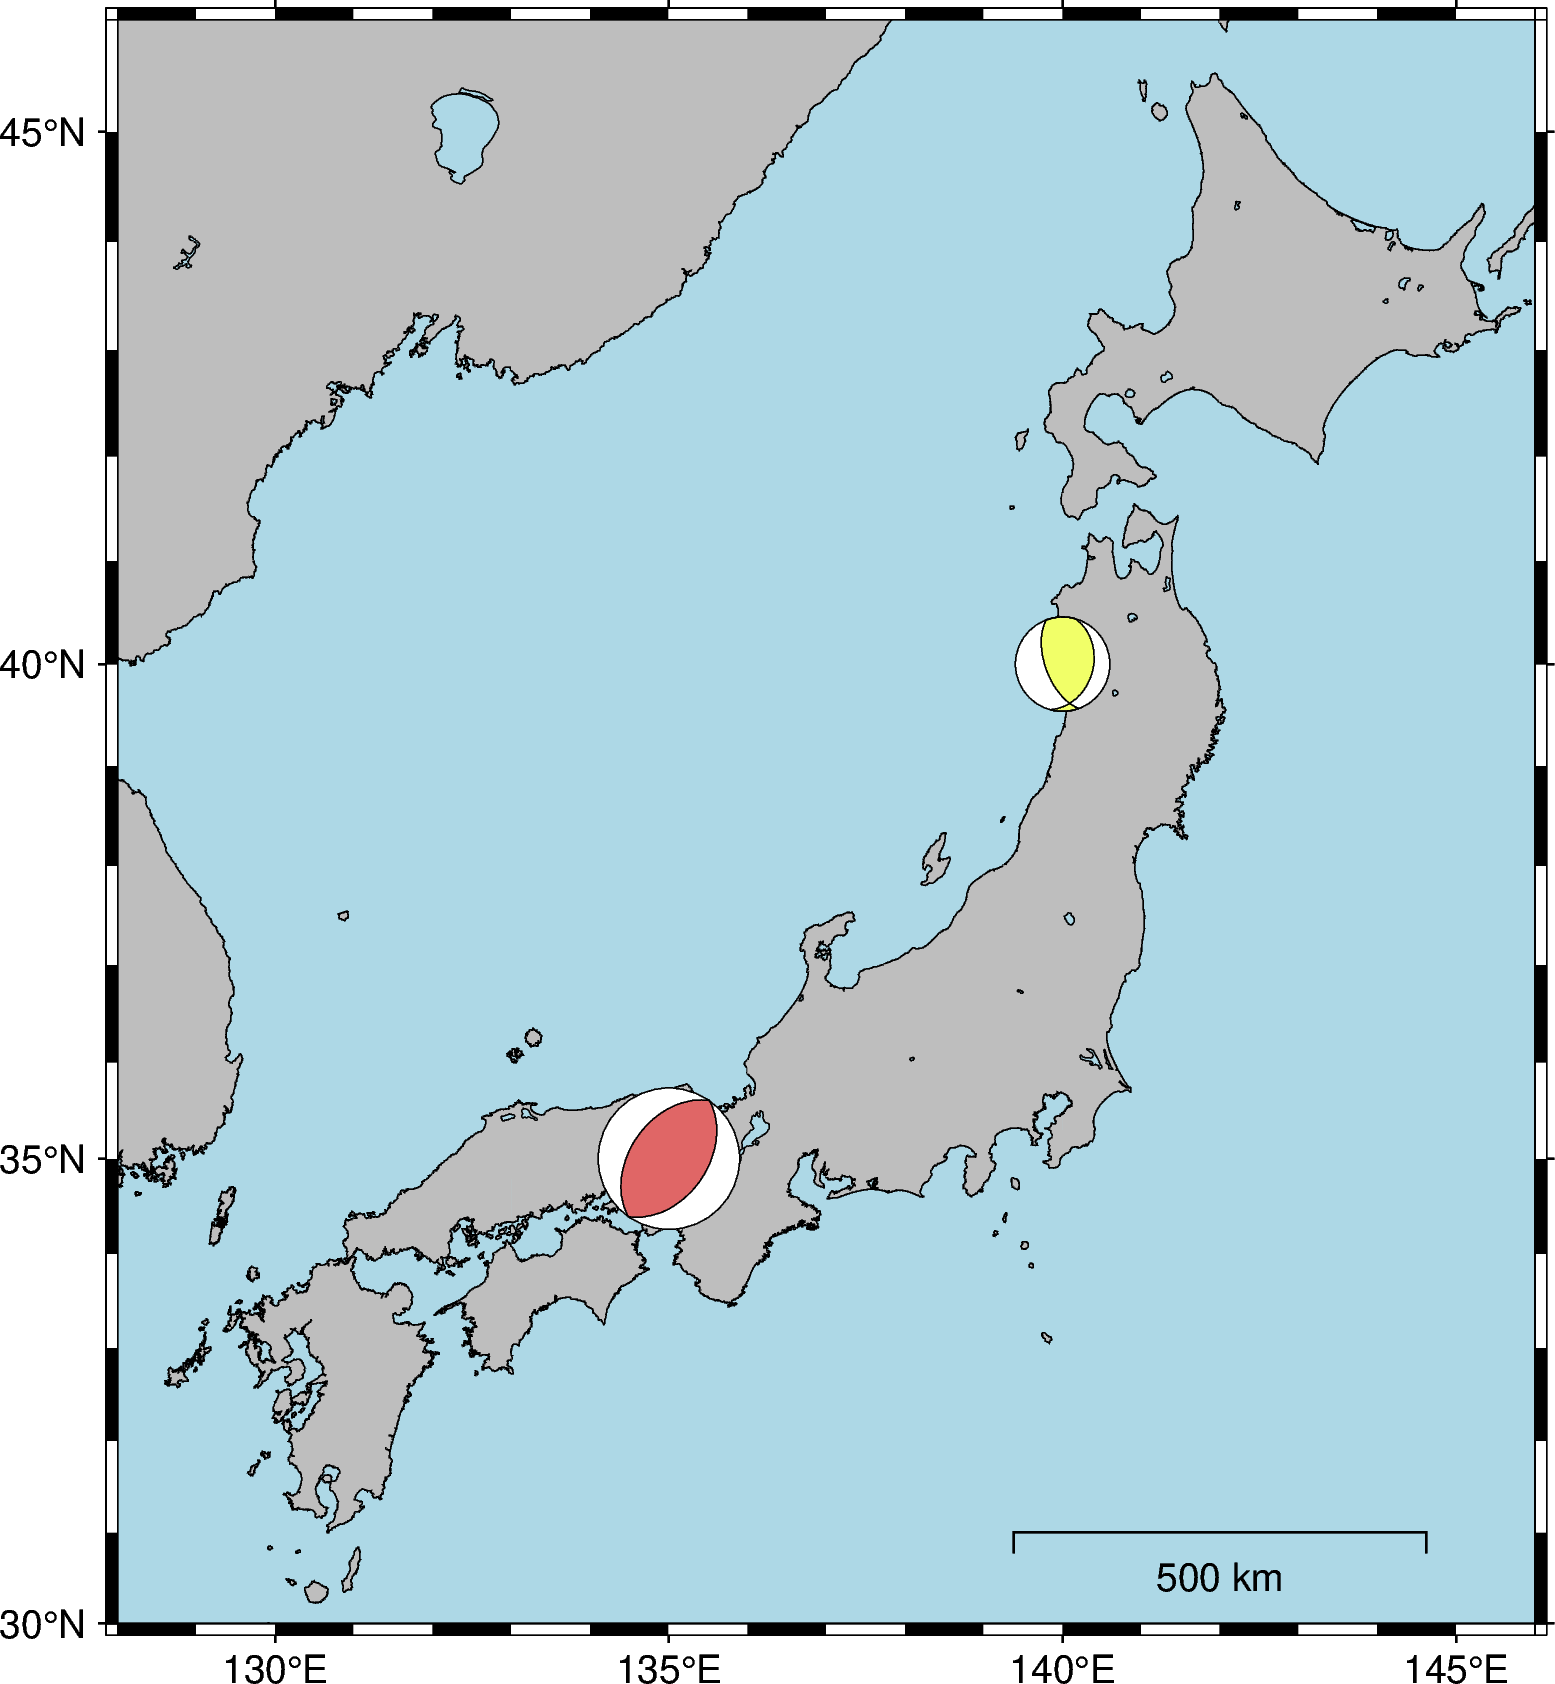

In [12]:
fig = pygmt.Figure()

fig.coast(
    projection  = 'M12c', 
    region      = [128, 146, 30, 46], 
    land        = 'grey', 
    water       = 'lightblue', 
    shorelines  = 'default,black', 
    area_thresh = 10,                           
    resolution  = 'f', 
    frame       = ['WSen', 'xaf', 'yaf'], 
    map_scale   = '142/31/31/500'
)

pygmt.makecpt(
    cmap         = 'seis',       
    series       = [0, 700, 50], 
    background   = True,         
    continuous   = True, 
    transparency = 40, 
)

fig.meca(spec  = meca, 
         scale = '1c', 
         cmap  = True, 
         outline = 'default,black'
)

fig.show()

````{note}
2023年9月公開のPyGMT `v0.10.0` で`meca` モジュールのオプションの実装が進み，GMT本家の `T` オプションに相当する `outline` が実装されて，だいぶ使いやすくなりました．

それ以前のバージョンでは，メカニズム解の押し部分への色塗りをひとつのモジュール呼び出しにまとめることができず，上記のスクリプトの `fig.meca` 部分を，以下のように2段階に分けて書く必要がありました．最新版を使うことをお勧めしますが，旧版をお使いの方のために情報として残しておきます．

```python
fig.meca(spec  = meca, 
         scale = '1c', 
         cmap  = True, 
)

# 節面を描画するにはもういちど fig.meca を `T` オプションをつけて呼ぶ
fig.meca(
    spec  = meca, 
    scale = '1c', 
    pen   = 'default,black', 
    T = '0'
)
```

なお，`meca` の `outline` オプションについては，染矢さん([`@msomeya1`](https://github.com/msomeya1)) に[ご教示](https://github.com/tktmyd/pygmt-howto-jp/issues/1)いただきました．記して感謝いたします．

````

## メカニズム解の鉛直断面表示

地図上ではなく，ある側線に沿った鉛直断面におけるメカニズム解を表示することがあります．このようなとき，プロットされるメカニズム解は水平な地図上での下半球投影ではなく，それを断面の角度に応じて投影したものを表示することが通例です．たとえば東西-鉛直断面を南側から見た場合，その断面の奥側，すなわち東半球が投影されます．

GMTでは，このような目的で [`coupe`](https://docs.generic-mapping-tools.org/latest/supplements/seis/coupe.html) というモジュールが提供されています．このモジュールはまさに上記のような目的を叶えるもので，震源メカニズムを鉛直断面上に表示します．

本家GMTにおける`coupe`利用の簡単な例として，3つのメカニズム解の東西鉛直断面と南北鉛直断面を表示するスクリプトの例を以下に示します．

```bash
#!/bin/bash

strike=180
dip1=5
dip2=80
dip3=15
rake1=30
rake2=15
rake3=-80

echo "1 3 1 $strike $dip1 $rake1 5 0 0" > meca.dat
echo "2 2 1 $strike $dip2 $rake2 5 0 0" >> meca.dat
echo "3 1 1 $strike $dip3 $rake3 5 0 0" >> meca.dat

gmt begin coupe_test png

    gmt basemap -R0/4/0/4 -JX10c/10c -BWseN -Bxaf+l"Easting" -Byaf+l"Northing" 
    gmt meca meca.dat -Sa2c -Gred -L 

    echo "1 3.5 ($strike, $dip1, $rake1)" | gmt text -F+f10p,Helvetica+jCB 
    echo "2 2.5 ($strike, $dip2, $rake2)" | gmt text -F+f10p,Helvetica+jCB 
    echo "3 1.5 ($strike, $dip3, $rake3)" | gmt text -F+f10p,Helvetica+jCB 
    echo "3.9 3.9 (@~f@~, @~d@~, @~l@~)"  | gmt text -F+f12p,Helvetica+jRT

    gmt coupe meca.dat -Ac0/2/4/2 -Sa2c -R0/4/0/2 -JX10c/-4c \
        -BWSen -Y-5c -Bxaf+l"Easting" -Bya1f0.2+l"Depth" -Gred -L
    gmt coupe meca.dat -Ac2/0/2/4 -Sa2c -R0/4/0/2 -JX10c/-4c \
        -BWSen -Y-5.5c -Bxaf+l"Northing" -Bya1f0.2+l"Depth" -Gred -L
    
gmt end
```

上記のスクリプトを実行すると，下図のようなメカニズム解とその鉛直断面図が得られます．

```{image} ./fig/coupe_test.png
:width: 50%
:align: center
```

```{note}
本来であれば南北断面については，横軸に深さ，縦軸に南北方向という座標系を取りたいところですが，筆者の知る限り `gmt coupe` でそれを実現することはできなさそうです．
```


ただし，残念なことに，`coupe` は`v.0.13.0`ではまだPyGMTには本モジュールが実装されていません．

この問題については，産業総合技術研究所の[佐脇](https://yasuit21.github.io/)さんが，独自実装した`coupe.py` とその使い方を [公開](https://yasuit21.github.io/ja/post/2023/09/0007/) されています．その中では実装の詳細についても解説されており，大変有意義です．

もちろんそれを使えば用は足りるのですが，ここではモーメントテンソルそのものの回転に基づく別の方法を考えます．

## モーメントテンソルと座標変換

PyGMTの `meca` モジュールは，（入力フォーマットは様々ですが，本質的には）モーメントテンソルを水平面内（XYもしくはlon-lat座標系）において下半球投影したものを可視化してくれます．ここでは，その `meca` モジュールはそのままに，モーメントテンソルのほうを座標変換してしまうことで，異なる方向から見たモーメントテンソルがプロットされるようにしてみます．具体的には，以下の図で模式的に示すような $(X,Y,Z)$から$(X', Y', Z')$（東西鉛直断面）あるいは$(X",Y",Z")$（南北鉛直断面）のような変換を考えます．

```{image} ./fig/Mech_cross_section.png
:width: 80%
```

ここでは，もともとのXYZ座標系として，Aki and Richards (2002)に倣って北（上）を$X$, 東（右）を $Y$, 深さ方向（奥）を $Z$ としました．それに対して東西鉛直断面では，上が$-Z$, 右が$Y$, 奥が$Z'$になりますから，

$$
X' = -Z, Y' = Y, Z' = X
$$

すなわち

$$
\begin{pmatrix} X'\\Y'\\Z' \end{pmatrix}
=
\begin{pmatrix} 0 & 0 & -1\\ 0 & 1 & 0 \\ 1 & 0 & 0 \end{pmatrix}
\begin{pmatrix} X\\Y\\Z \end{pmatrix}
$$

で座標変換が表されます．

同様に，上図から南北-鉛直断面を鉛直方向を右に表示するには，

$$
\begin{pmatrix} X''\\Y''\\Z'' \end{pmatrix}
=
\begin{pmatrix} 1 & 0 & 0\\ 0 & 0 & 1 \\ 0 & -1 & 0 \end{pmatrix}
\begin{pmatrix} X\\Y\\Z \end{pmatrix}
$$

とすればよいことがわかります．


一般に，座標系$O(XYZ)$から$O(X'Y'Z')$への座標変換が行列$\boldsymbol{R}$で与えられるとき，$O(XYZ)$における2階のテンソル$\boldsymbol{M}$は$O(X'Y'Z')$において

$$
\boldsymbol{M}' = \boldsymbol{R M R}^T
$$

と表されます．このことを用いると，東西鉛直断面表示をするためのモーメントテンソルは

$$
\begin{pmatrix} M'_{xx} & M'_{xy} &M'_{xz} \\ M'_{xy} & M'_{yy} &M'_{yz} \\ M'_{xz} & M'_{yz} &M'_{zz} \end{pmatrix}
=
\begin{pmatrix} M_{zz} & - M_{yz} & -M_{xz} \\ - M_{yz} & M_{yy} & M_{xy} \\ - M_{xz} & M_{xy} & M_{xx} \end{pmatrix}
$$

南北鉛直断面については，

$$
\begin{pmatrix} M''_{xx} & M''_{xy} &M''_{xz} \\ M''_{xy} & M''_{yy} &M''_{yz} \\ M''_{xz} & M''_{yz} &M''_{zz} \end{pmatrix}
=
\begin{pmatrix} M_{xx} & M_{xz} & -M_{xy} \\ M_{xz} & M_{zz} & -M_{yz} \\ - M_{xy} & -M_{yz} & M_{yy} \end{pmatrix}
$$

であることが導かれます．

ところで，もし `aki` フォーマットで `strike`, `dip`, `rake` および `Mw` をもってメカニズム解を指定した場合，上記の方法を用いるためには，まずそれをモーメントテンソル成分に変換しなければなりません．しかも，`meca`モジュールの `mt` フォーマットは，極座標におけるモーメントテンソル成分を入力として要求します．

まず，`strike` $\phi$, `dip` $\delta$, `rake` $\lambda$ と地震モーメント $M_0$ が与えられたとき，上図のような北を$X$軸にとる直交座標系におけるモーメントテンソルは，

$$
\begin{align}
    &M_{xx} = - M_0  (\sin\delta * \cos\lambda * \sin2\phi + \sin2\delta * \sin\lambda * \sin\phi * \sin\phi )\\
    &M_{xy} = \,\,\,\, M_0  (\sin\delta * \cos\lambda * \cos2\phi + \sin2\delta * \sin\lambda * \sin2\phi / 2    )\\
    &M_{xz} = - M_0  (\cos\delta * \cos\lambda * \cos\phi  + \cos2\delta * \sin\lambda * \sin\phi         )\\
    &M_{yy} = \,\,\,\, M_0  (\sin\delta * \cos\lambda * \sin2\phi - \sin2\delta * \sin\lambda * \cos\phi * \cos\phi )\\
    &M_{yz} = - M_0  (\cos\delta * \cos\lambda * \sin\phi  - \cos2\delta * \sin\lambda * \cos\phi         )\\
    &M_{zz} = \,\,\,\, M_0  (                         \sin2\delta * \sin\lambda                 )
\end{align}
$$

の関係にあります．加えて，$O(r\theta\phi)$の極座標系におけるモーメントテンソルは，この直交座標系におけるモーメントテンソルと，

$$
\begin{pmatrix}
M_{rr} & M_{r\theta} & M_{r\phi}\\
M_{r\theta} & M_{\theta \theta} & M_{\theta \phi}\\
M_{r \phi} & M_{\theta \phi} & M_{\phi \phi} 
\end{pmatrix}
= 
\begin{pmatrix}
M_{zz} & M_{xz} & -M_{yz} \\
M_{xz} & M_{xx} & -M_{xy} \\
-M_{yz} & M_{yx} & M_{yy}
\end{pmatrix}
$$

という関係があります (Aki and Richards, 2002, p. 113 Box 4.4)．これらを用いて，

1. strike, dip, rake から直交座標系のモーメントテンソルに変換
2. 1.の結果を断面に応じて座標変換
3. 2.の結果を極座標のモーメントテンソルに変換

という3つのステップによって鉛直断面を投影できます．

それでは，実践してみましょう．上記1.と2.の手続きをそれぞれ関数化しておきます．

In [13]:
def sdr2moment(strike, dip, rake, M0): 
    """calculate moment tensor component from strike, dip, and rake """

    sinδ  = np.sin(    np.deg2rad(dip   ))
    cosδ  = np.cos(    np.deg2rad(dip   ))
    sin2δ = np.sin(2 * np.deg2rad(dip   ))
    cos2δ = np.cos(2 * np.deg2rad(dip   ))
    sinλ  = np.sin(    np.deg2rad(rake  ))
    cosλ  = np.cos(    np.deg2rad(rake  ))
    sinφ  = np.sin(    np.deg2rad(strike))
    cosφ  = np.cos(    np.deg2rad(strike))
    sin2φ = np.sin(2 * np.deg2rad(strike))
    cos2φ = np.cos(2 * np.deg2rad(strike))
    
    Mxx = - M0 * (sinδ * cosλ * sin2φ + sin2δ * sinλ * sinφ * sinφ )
    Mxy =   M0 * (sinδ * cosλ * cos2φ + sin2δ * sinλ * sin2φ / 2    )
    Mxz = - M0 * (cosδ * cosλ * cosφ  + cos2δ * sinλ * sinφ         )
    Myy =   M0 * (sinδ * cosλ * sin2φ - sin2δ * sinλ * cosφ * cosφ )
    Myz = - M0 * (cosδ * cosλ * sinφ  - cos2δ * sinλ * cosφ         )
    Mzz =   M0 * (                         sin2δ * sinλ                 )

    return Mxx, Myy, Mzz, Myz, Mxz, Mxy


def meca_crosssection(strike, dip, rake, Mw, orient='E'): 

    M0 = 10**( 1.5 * (Mw + 10.7) ) # in dyn-cm unit
    exponent = int(np.floor(np.log10(M0)))
    Mxx, Myy, Mzz, Myz, Mxz, Mxy = sdr2moment(strike, dip, rake, M0/10**exponent)

    # Coordinate transform
    if orient == 'E':
        Mxx, Myy, Mzz, Myz, Mxz, Mxy = Mzz, Myy, Mxx, Mxy, -Mxz, -Myz
    else: 
        Mxx, Myy, Mzz, Myz, Mxz, Mxy = Mxx, Mzz, Myy, -Myz, -Mxy, Mxz
        
    # Polar Coordinate
    Mrr, Mtt, Mff, Mtf, Mrf, Mrt = Mzz, Mxx, Myy, -Mxy, -Myz, Mxz

    # Data for plotting by pygmt.Figure.meca
    spec = {"mrr": Mrr, "mtt": Mtt, "mff": Mff, 
            "mrf": Mrf, "mrt": Mrt, "mtf": Mtf, 
            "exponent": exponent}

    return spec

`meca` の `mt` フォーマットでは，パラメタ `exponent` を使って `10^(exponent)` を地震モーメントから $M_0$ から括りだしているということ，また地震モーメントは Nm ではなく dyn cm の単位系で表現している，ということに注意してください．

そのうえで，先の `bash` スクリプトと同等の図を作成するには，以下のようにします．

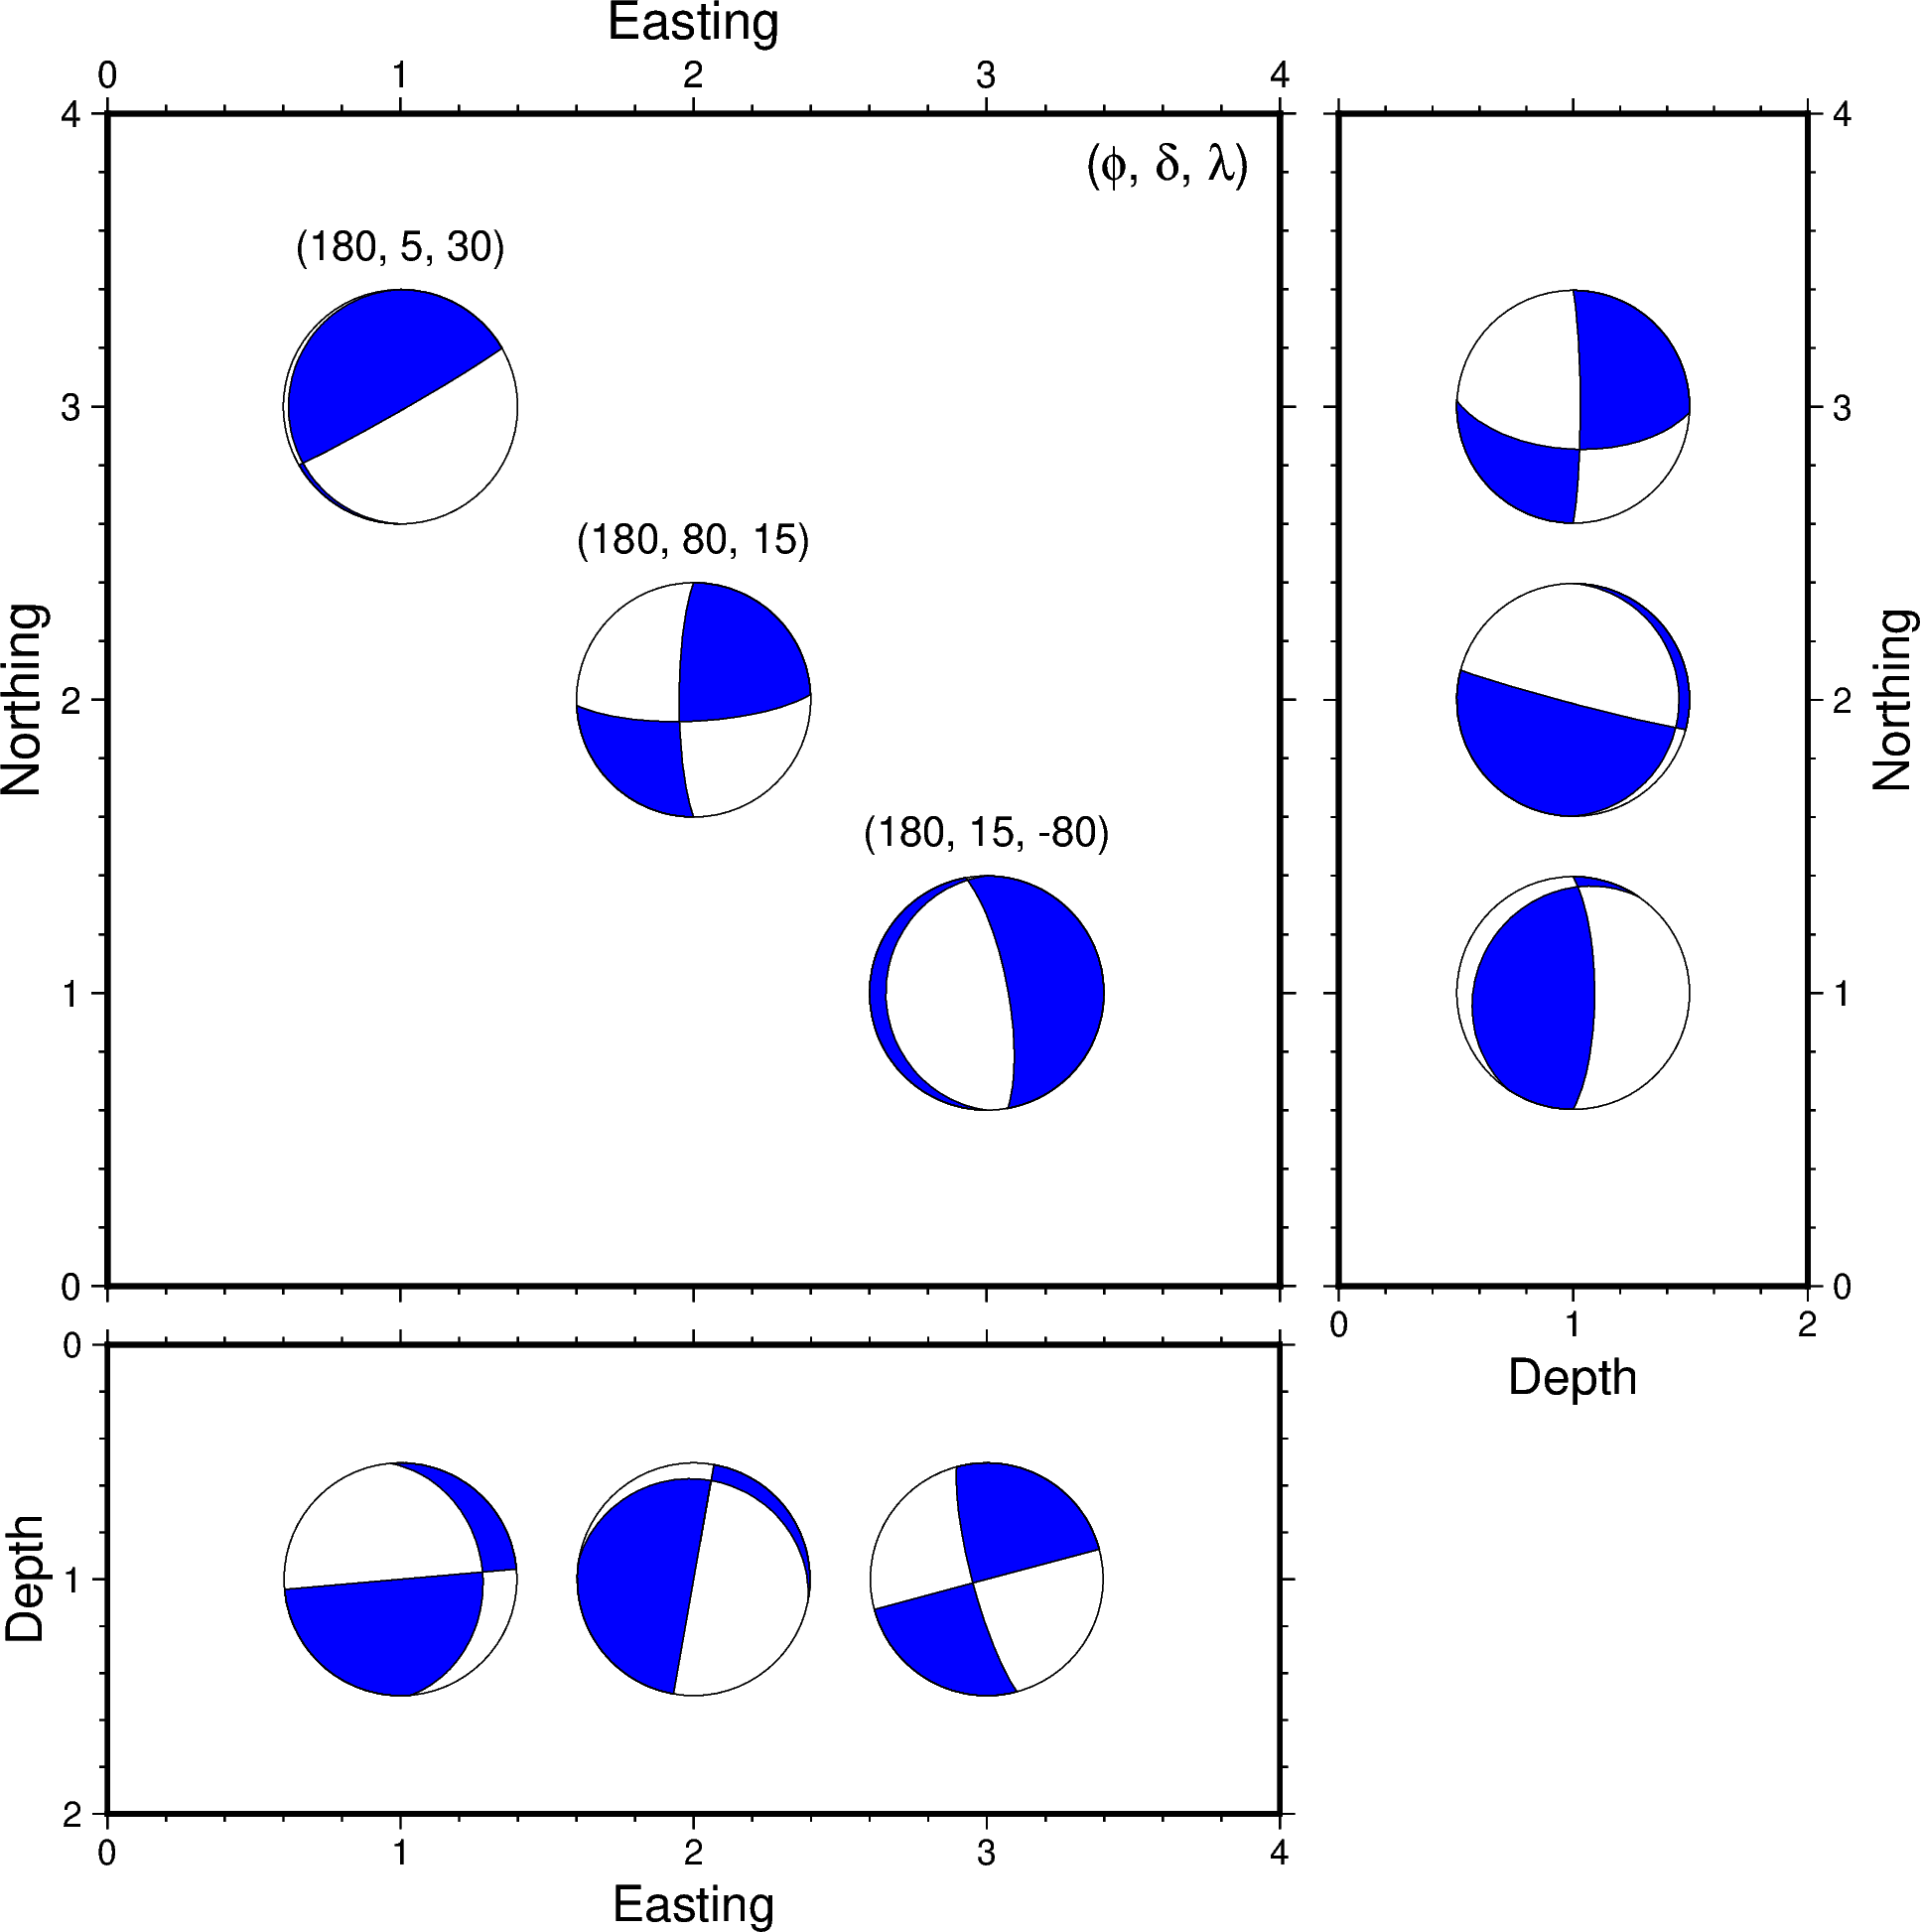

In [14]:
strike = 180
dip1 = 5
dip2 = 80
dip3 = 15
rake1 = 30
rake2 = 15
rake3 = -80

fig = pygmt.Figure()

fig.basemap(projection = 'X10c/10c', region = [0, 4, 0, 4], 
            frame = ['WseN', 'xaf+lEasting', 'yaf+lNorthing'])
for lon, lat, dip, rake in zip([1, 2, 3], [3, 2, 1], 
                               [dip1, dip2, dip3], [rake1, rake2, rake3]):
    fig.meca(spec={'strike':strike, 'dip':dip, 'rake': rake, 'magnitude': 5}, 
             longitude = lon, latitude = lat, depth = 1, scale = '2c', 
             compressionfill = 'blue', outline = 'default,black')
    fig.text(justify='CB', x = lon, y = lat + 0.5, 
             text = f'({strike}, {dip}, {rake})', 
             font = '10p,Helvetica,Black')

fig.text(justify='RT', x = 3.9, y = 3.9, 
         text = '(@~f@~, @~d@~, @~l@~)', font = '12p,Helvetica,Black')

fig.shift_origin(0, -4.5)

# E-Z cross section
fig.basemap(projection = 'X10c/-4c', region = [0, 4, 0, 2], 
            frame = ['WSen', 'xaf+lEasting', 'ya1f0.2+lDepth'])

for lon, dip, rake in zip([1, 2, 3],  
                          [dip1, dip2, dip3], [rake1, rake2, rake3]):

    fig.meca(spec=meca_crosssection(strike, dip, rake, 5, orient='E'), 
             longitude = lon, latitude = 1, depth = 0, scale = '2c', 
             compressionfill = 'blue', outline = 'default,black')  

fig.shift_origin(10.5, 4.5)

# N-Z cross section
fig.basemap(projection = 'X4c/10c', region = [0, 2, 0, 4], 
            frame = ['wSEn', 'xa1f0.2+lDepth', 'yaf+lNorthing'])


for lat, dip, rake in zip([3, 2, 1],  
                          [dip1, dip2, dip3], [rake1, rake2, rake3]):

    fig.meca(spec=meca_crosssection(strike, dip, rake, 5, orient='N'), 
             longitude = 1, latitude = lat, depth = 0, scale = '2c', 
             compressionfill = 'blue', outline = 'default,black')  

fig.show()

本家 `gmt coupe` とは異なり，自力でモーメントテンソルを座標変換しているので，その行列の定義を注意深く行えば，この例のように南北断面を横軸深さ，縦軸南北にすることも容易です．これを，`strike` 角だけを少しずつ変えながら [こちらのページ](./animation.ipynb) で解説している方法で gifアニメーションにすると以下のようになります．

```{image} fig/meca_rot.gif
:width: 60%
:align: center
```

```{warning}

上記の例を作成している途上で，特定の(`strike`, `dip`, `rake`) の組み合わせをモーメントテンソルに変換してから `meca` で表示すると，表示されるメカニズム解の押し引きが反転してしまう，というバグに遭遇しました．この問題はモーメントテンソル対角成分のうち一つが$0$に十分近くなるときに起こりうる（いつでもとは限りません）ようです．`strike`, `dip`, `rake` の角度が整数値では，（90度とか270度などのキリの良い数字で）そういうことが発生しがちであるため，上記のアニメーションではこれらの角度値に対して描画結果に影響が出ないくらい小さな値（0.0001度）を加えて描画しています．

このバグについては[報告](https://github.com/GenericMappingTools/pygmt/issues/3682) してあり，またGMT本家でも類似の [報告](https://github.com/GenericMappingTools/gmt/issues/8009) や，[Q&A](https://forum.generic-mapping-tools.org/t/psmeca-moment-tensor-behavior/3076)でも似たような問題が挙げられているようです．

```